# The Heston Model : Simulation exacte

Done by : BAHOUS Youness / DARIA Taha

The model SDE

\begin{array}{l}
dS_{t}=rS_{t}dt+\sqrt{V_{t}}S_{t}dW_{t}\\
dV_{t}=-k\left(V_{t}-\theta\right)dt+\sigma\sqrt{V_{t}}dZ_{t}
\end{array}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

# Params
K = 50 # A strike for the option to price
T = 1 # Maturity of the option
S0 = 50 # An initial value for the  asset
V0 = 0.1 # An initial value for the variance process
r = 0.1 # Interest rate
theta = 0.1 # Mean of Variance
kappa = 0.2 # Mean reversion speen (CIR)
rho = 0.1 # Correlation of two brownians
sigma_v= 0.3 # Volatilty of volatility


In [2]:
def GS_star(alpha):
    while True:
      b = (alpha + np.e )/np.e
      y = np.random.uniform(0,1,1) * b
      if y <= 1:
          x = (y)**(1/alpha)
          w = np.random.exponential(1,1)
          if w > x:
              return x
      else:
          x = -np.log((b-y)/alpha)
          w = np.random.uniform(0,1,1)**(1/(alpha-1))
          if w <= x:
              return x

# use if alpha > 1

def GKM1(alpha):
    a = alpha - 1
    b = (alpha - 1/(6*alpha))/a
    m = 2/a
    d= m + 2

    while True:
        x = np.random.uniform(0,1,1)
        y = np.random.uniform(0,1,1)
        v = b*y/x
        if m*x - d + v + 1/v <= 0:
            return a*v
        if m*np.log(x) - np.log(v) + v - 1 <= 0:
            return a*v


def GKM2(alpha):
    a = alpha - 1
    b = ( alpha - 1/(6*alpha) ) / a
    m = 2/a
    d = m + 2
    f = np.sqrt(alpha)
    while( True ):
        while( True ):
            #generate X uniform in (0,1)
            X = np.random.rand()
            Yprime = np.random.rand()
            Xprime = Yprime + (1 - 1.857764 * X) / f
            if (Xprime > 0 and Xprime < 1):
                break
        v = b*Yprime/Xprime
        if(m*Xprime - d + v + 1/v <= 0):
            break
        if(m * np.log(Xprime) - np.log(v) + v - 1 <= 0):
            break
    return a * v

def GKM3(alpha, alpha0 = 2.5):
  if alpha <= alpha0 :
    return GKM1(alpha)
  else :
    return GKM2(alpha)

def simchi2(d):
    # xi^2_d === Gamma(d/2,2)
    if d/2 < 1:
        return GS_star(d/2)*2
    if d/2 > 1:
        return GKM3(d/2)*2
    if d/2 == 1:
        return np.random.exponential(2,1)

def non_centrical_chi_2(d , lambda_):
    # d is the number of degrees of freedom
    N = np.random.poisson(1/2*lambda_,1)
    x = simchi2(d+2*N)
    return x

In [3]:

u = 0.6 # This is an example value for u
t = 0.67 # t must be greater than u, this is an example value for t
V_u = 0.2 # This is an example value for V_u



In [4]:
def VtGivenV0(kappa,theta, sigma_v, u, t, V_u):

    # Calculate d using the equation d = 4*kappa/sigma_v^2
    d = 4 * kappa*theta / sigma_v**2

    # Compute the scale factor for the noncentral chi-squared distribution
    scale_factor = (sigma_v**2 * (1 - np.exp(-kappa * (t - u)))) / (4 * kappa)

    # Compute the noncentrality parameter for the noncentral chi-squared distribution
    noncentrality_param = (4 * kappa * np.exp(-kappa * (t - u)) * V_u) / (sigma_v**2 * (1 - np.exp(-kappa * (t - u))))

    # Draw a sample from the noncentral chi-squared distribution
    V_t_sample = scale_factor *non_centrical_chi_2(d, noncentrality_param) #

    return V_t_sample

V_t = VtGivenV0(kappa,theta, sigma_v, u, t, V_u)

print(f"V_t = {V_t}")

V_t = [0.15136841]


In [5]:
from scipy.special import iv

def safe_divide(a, b, eps=np.finfo(float).eps):
    """Perform safe division, replacing small denominators with eps."""
    return a / np.where(np.abs(b) < eps, eps, b)

def safe_sqrt(x, eps=np.finfo(float).eps):
    """Compute a safe square root, ensuring the argument is nonnegative."""
    return np.sqrt(np.maximum(x, eps))

def calculate_phi(a, kappa, theta, sigma_v, u, t, V_u, V_t):
    eps = np.finfo(float).eps
    # Calculate d using the equation d = 4*kappa/sigma_v^2
    d = 4 * kappa * theta/ sigma_v**2

    # Calculate γ(a)
    gamma_a = np.sqrt(kappa**2 - 2*1j*a*sigma_v**2)

    # Calculate the complex exponential term
    exp_term = np.exp(-1j*a*u + gamma_a*(1 - np.exp(-kappa*(t-u))))


    # Calculate the Bessel function ratio
    bessel_ratio = iv(0.5*d - 1, 4*gamma_a*np.sqrt(V_u*V_t)*np.exp(-0.5*gamma_a*(t-u))/ (eps + (sigma_v**2)*(1 - np.exp(-gamma_a*(t-u))))) \
                  / (iv(0.5*d - 1, 4*kappa*np.exp(-0.5*kappa*(t-u))*np.sqrt(V_u*V_t) / (eps + (sigma_v**2)*(1 - np.exp(-kappa*(t-u))))))

    # Calcul des exponentielles
    exp_term1 = np.exp(-1/2 * (gamma_a - kappa) * (t - u))
    exp_term2 = np.exp(-kappa * (t - u))
    exp_term3 = np.exp(-gamma_a * (t - u))

    # Calcul des termes dans les crochets de l'exponentielle
    bracket_term1 = (V_u + V_t) / sigma_v**2
    bracket_term2 = kappa * (1 + exp_term2) / (1 - exp_term2 )
    bracket_term3 = -gamma_a * (1 + exp_term3) / (1 - exp_term3)
    # Combine terms to get Φ(a)
    # Combinaison des termes pour la formule finale
    phi_a = (gamma_a * exp_term1 * (1 - exp_term2) /
                  (kappa * (1 - exp_term3)) *
                  np.exp(bracket_term1 * (bracket_term2 + bracket_term3))) * bessel_ratio

    return phi_a


def compute_mean_and_variance(phi_function, kappa, theta, sigma_v, u, t, V_u, V_t, epsilon=1e-5):
    # Compute the first derivative at t=0 for mean
    phi_prime = (phi_function(epsilon, kappa, theta, sigma_v, u, t, V_u, V_t) - phi_function(-epsilon, kappa, theta, sigma_v, u, t, V_u, V_t)) / (2 * epsilon)
    # Compute the second derivative at t=0 for variance
    phi_double_prime = (phi_function(epsilon, kappa, theta, sigma_v, u, t, V_u, V_t) - 2 * phi_function(0, kappa, theta, sigma_v, u, t, V_u, V_t) + phi_function(-epsilon, kappa, theta, sigma_v, u, t, V_u, V_t)) / epsilon**2
    mean = phi_prime.imag / phi_function(0, kappa, theta, sigma_v, u, t, V_u, V_t).real
    variance = -phi_double_prime.imag / phi_function(0, kappa, theta, sigma_v, u, t, V_u, V_t).real
    return mean, variance

Maintenant on peut approximer la fonction de repartition de la variable aléatoire : l'integrale de Vs

Le plan est le suivant :
- On va utiliser The (Inverse) Distribution Function Method for sampling mais on ne connait pas F-1 donc on faire comme suit :
- On genere U uniforme.
- On utilise la methode de newton pour trouver x tel que F(x) = U.
- Pour chaque calcul de F(x) on utilise une approximation qui fait appel à phi codée précedement.

In [6]:
def F(x, u, t, V_u, V_t, h, N):
    somme = 0
    for j in range(1, N + 1):
        phi_val = calculate_phi(h * j, kappa , theta, sigma_v, u, t, V_u, V_t)
        term =  (np.sin(h * j * x) / j) * phi_val.real
        somme += term

    F_x = (h * x / np.pi) + (2 / np.pi) * somme

    return F_x

def Fprime(x, u, t, V_u, V_t, h, N):
    somme = 0
    for j in range(1, N + 1):
        phi_val = calculate_phi(h * j, kappa, theta , sigma_v, u, t, V_u, V_t)
        term =  (np.cos(h * j * x) * h) * phi_val.real
        somme += term

    F_x = (h / np.pi) + (2 / np.pi) * somme
    return F_x


def Fseconde(x, u, t, V_u, V_t, h, N):
    somme = 0
    for j in range(1, N + 1):
        phi_val = calculate_phi(h * j, kappa,theta, sigma_v, u, t, V_u, V_t)
        term =  (-np.sin(h * j * x) * h * h * j) * phi_val.real
        somme += term

    F_x = (h / np.pi) * somme
    return F_x



In [7]:
def simulate_integral_V(V_u, V_t, u, t, exact_mean, exact_variance, N, N_iter=5):
    eps = np.finfo(float).eps
    rr = np.random.uniform(0, 1)

    # Initial guess for x
    x = exact_variance * np.random.randn() + exact_mean
    if x < 0:
        x = 0.01 * exact_mean

    # Newton's method
    for i in range(N_iter):
        h = 2 * np.pi / (x + 1)
        f = F(x, u, t, V_u, V_t, h, N) - rr
        fp = Fprime(x, u, t, V_u, V_t, h, N)
        fpp = Fseconde(x, u, t, V_u, V_t, h, N)

        # Compute the update term for Newton's method, ensuring no division by very small numbers.
        update_term = fp/fpp * (1 - safe_sqrt(1 - 2 * fpp * f / (fp**2)))
        x = x - update_term

    return x


In [8]:
def genrerer_s(S_u ,i , V_u , V_t , kappa, sigma_v , theta , u,t , r , rho):
  # integral de sqrt(V)dW
  ii = 1/sigma_v * (V_t-V_u - kappa * theta * (t-u) + kappa * i)
  m =  r*(t-u) -1/2*i + rho*ii
  s = np.sqrt((1-rho**2)*i)
  z = np.random.randn()
  S_t = S_u*  np.exp(m + s*z)
  #print(S_u ,i , V_u , V_t , kappa, sigma_v , theta , u,t , r , rho)
  return S_t


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_path(S_0, V_0, kappa, sigma_v, theta, T, r, rho, N):
    # Initialize arrays to store stock prices (S) and variance (V)
    S = np.zeros(N)
    V = np.zeros(N)
    # Generate time points
    times = np.linspace(0, T, N)

    # Set initial conditions
    S[0] = S_0
    V[0] = V_0

    # Iterate through each time step to compute S and V
    for i in range(1, N):
        # Compute the next variance using a given function
        V[i] = VtGivenV0(kappa, theta, sigma_v, times[i-1], times[i], V[i-1])

        V[i] = max(V[i], 0)
        # Compute exact mean and variance for the integral simulation
        exact_mean, exact_variance = compute_mean_and_variance(calculate_phi,kappa, theta, sigma_v, times[i-1], times[i] ,  V[i-1], V[i])

        # Simulate the integral for the SDE
        integ = simulate_integral_V(V[i-1], V[i], times[i-1], times[i], exact_mean, exact_variance, N, N_iter=5)
        S[i] = genrerer_s(S[i-1], integ, V[i-1], V[i], kappa, sigma_v, theta, times[i-1], times[i], r, rho)
        if np.isnan(S[i]):
            # Placeholder for potential NaN handling
            S[i] = S[i-1]  # Simplest approach: use the previous value

    return S, V


<ipython-input-9-42b279269fcb>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[i] = VtGivenV0(kappa, theta, sigma_v, times[i-1], times[i], V[i-1])


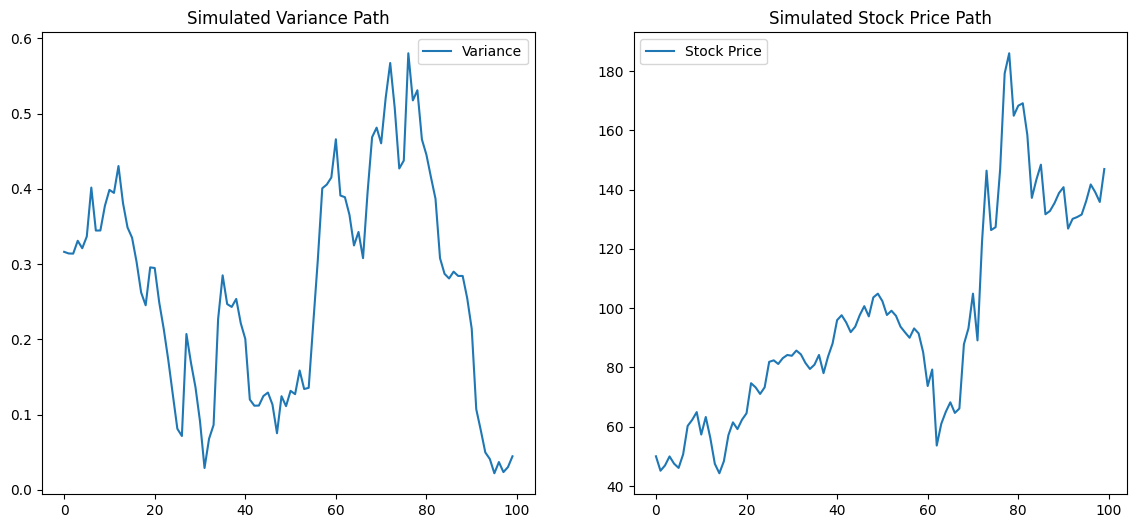

In [10]:


# Generate the path
S, V = generate_path(S0, V0, kappa, sigma_v, theta, 10, r, rho, 100)

# Plot the results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(np.sqrt(V), label='Variance')
plt.title('Simulated Variance Path')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(S, label='Stock Price')
plt.title('Simulated Stock Price Path')
plt.legend()

plt.show()